In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Input, AveragePooling2D
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical 
from keras.applications.mobilenet_v2 import preprocess_input 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

In [4]:
DIRECTORY = 'Dataset'    # Path to the Datasets 
CATEGORIES = ['fire', 'no_fire']

data = []
labels = []

for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category) 
  for img in os.listdir(path):
    img_path = os.path.join(path, img) 
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
print(data.shape)
print(labels.shape)

(6724, 224, 224, 3)
(6724, 2)


In [8]:
(X_train_full, X_test, y_train_full, y_test) = train_test_split(data, labels, test_size = 0.20, stratify = labels)

In [9]:
print('X_train_full shape:', X_train_full.shape)
print('y_train_full shape:', y_train_full.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (5379, 224, 224, 3)
y_train_full shape: (5379, 2)
X_test shape: (1345, 224, 224, 3)
y_test shape: (1345, 2)


In [10]:
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train_full, y_train_full, test_size = 0.10, stratify = y_train_full)

In [11]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)

X_train shape: (4841, 224, 224, 3)
y_train shape: (4841, 2)
X_valid shape: (538, 224, 224, 3)
y_valid shape: (538, 2)


In [12]:
dataAug = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2,
                             fill_mode='nearest')

In [13]:
INIT_LR = 1e-4  
EPOCHS = 10
BS = 32

In [14]:
def FireNet():

  baseModel = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  Inputs = baseModel.input
  headModel = baseModel.output 
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name='Flatten')(headModel)
  headModel = Dense(256, activation='relu')(headModel)
  headModel = Dropout(0.50)(headModel)
  headModel = Dense(128, activation='relu')(headModel)
  headModel = Dropout(0.50)(headModel)
  headModel = Dense(2, activation='softmax')(headModel)

  fire_net = Model(inputs = Inputs, outputs = headModel)
  
  for layer in baseModel.layers[:10]:
    layer.trainable = False
  
  adam = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
  fire_net.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  fire_net.summary()

  return fire_net

In [15]:
fire_net = FireNet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [16]:
H = fire_net.fit(dataAug.flow(X_train, y_train, batch_size=BS), 
                      steps_per_epoch = len(X_train) // BS,
                      validation_data = (X_valid, y_valid),
                      epochs = EPOCHS)

Epoch 1/10
151/151 [==============================] - 514s 3s/step - loss: 0.2995 - accuracy: 0.8917 - val_loss: 0.0768 - val_accuracy: 0.9796
Epoch 2/10
151/151 [==============================] - 472s 3s/step - loss: 0.1213 - accuracy: 0.9628 - val_loss: 0.0640 - val_accuracy: 0.9870
Epoch 3/10
151/151 [==============================] - 447s 3s/step - loss: 0.0938 - accuracy: 0.9734 - val_loss: 0.1088 - val_accuracy: 0.9814
Epoch 4/10
151/151 [==============================] - 445s 3s/step - loss: 0.0660 - accuracy: 0.9798 - val_loss: 0.0443 - val_accuracy: 0.9888
Epoch 5/10
151/151 [==============================] - 449s 3s/step - loss: 0.0572 - accuracy: 0.9827 - val_loss: 0.0693 - val_accuracy: 0.9888
Epoch 6/10
151/151 [==============================] - 457s 3s/step - loss: 0.0595 - accuracy: 0.9802 - val_loss: 0.0860 - val_accuracy: 0.9888
Epoch 7/10
151/151 [==============================] - 494s 3s/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.0738 - val_accuracy: 0.9907

In [17]:
fire_net.save('finall', save_format='h5')

In [18]:
pred = fire_net.predict(X_test)
predictions = np.argmax(pred, axis=1)
actual_labels = np.argmax(y_test, axis=1)

43/43 [==============================] - 27s 625ms/step


In [19]:
print(pred.shape)
print(predictions.shape)
print(actual_labels.shape)
print(y_train.shape)

(1345, 2)
(1345,)
(1345,)
(4841, 2)


In [20]:
classes = ['Fire', 'No-Fire']

In [21]:
part_prediction = []
part_actual_labels = []
for i, j in zip(predictions[:10], actual_labels[:10]):
  part_prediction.append(classes[i])
  part_actual_labels.append(classes[j])

In [22]:
partial_data = {'Predictions' : part_prediction, 'Actual Labels' : part_actual_labels}
df = pd.DataFrame(partial_data)
df

,Predictions,Actual Labels
0,Fire,Fire
1,No-Fire,No-Fire
2,Fire,Fire
3,Fire,Fire
4,No-Fire,No-Fire
5,No-Fire,No-Fire
6,No-Fire,No-Fire
7,Fire,Fire
8,No-Fire,No-Fire
9,No-Fire,No-Fire


In [23]:
n_img = 8
X_new = X_test[:n_img]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


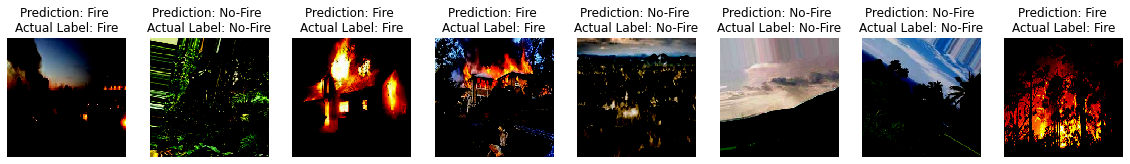

In [24]:
plt.figure(figsize=(2.5 * n_img, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, n_img, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(f'Prediction: {classes[predictions[index]]} \nActual Label: {classes[actual_labels[index]]}', fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [25]:
fire_net.evaluate(X_test, y_test)

43/43 [==============================] - 29s 673ms/step - loss: 0.2503 - accuracy: 0.9740


[0.2503337860107422, 0.9739776849746704]

In [26]:
precision = round(precision_score(actual_labels, predictions) * 100, 2)
accuracy = round(accuracy_score(actual_labels, predictions) * 100, 2)
recall = round(recall_score(actual_labels, predictions) * 100, 2)
f1 = round(f1_score(actual_labels, predictions) * 100, 2)
conf_mat = confusion_matrix(actual_labels, predictions)

In [27]:
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Confusion Matrix:\n {conf_mat}')

Accuracy: 97.4%
Precision: 94.71%
Recall: 99.66
F1-score: 97.12
Confusion Matrix:
 [[719  33]
 [  2 591]]


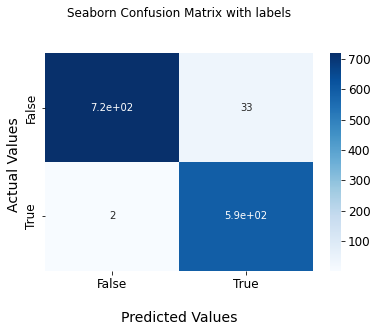

In [36]:
import seaborn as sns

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show() 

In [28]:
print(classification_report(actual_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       752
           1       0.95      1.00      0.97       593

    accuracy                           0.97      1345
   macro avg       0.97      0.98      0.97      1345
weighted avg       0.98      0.97      0.97      1345



In [29]:
fpr, tpr, thresholds = roc_curve(actual_labels, predictions)

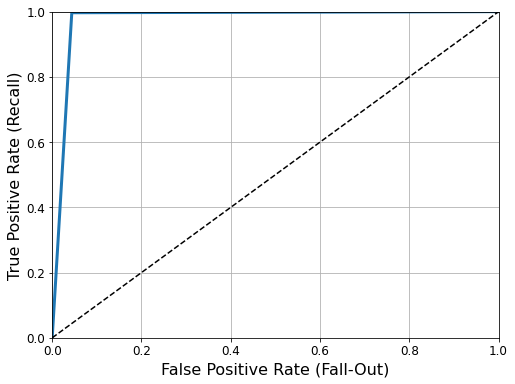

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Fire-Detector/Plots/roc/plot-2.png'

<Figure size 432x288 with 0 Axes>

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=3, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.show()
plt.savefig("/content/drive/MyDrive/Fire-Detector/Plots/roc/plot-2.png")

In [31]:
roc_auc_score(actual_labels, predictions)

0.9763721699974883

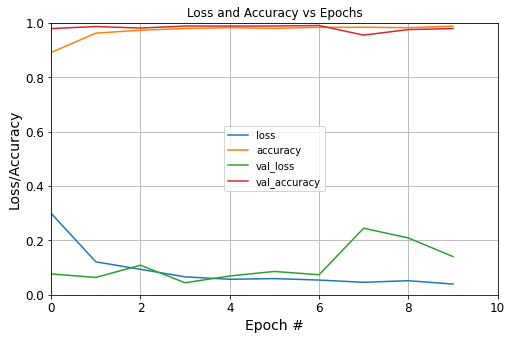

In [32]:
pd.DataFrame(H.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, EPOCHS)
plt.title("Loss and Accuracy vs Epochs")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center")
plt.show()